# Pneumonia Detection in chest X-ray images using CNNs and Transfer Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mariostrbac/pneumonia-detection-in-chest-xrays/blob/main/notebooks/xray_pneumonia_detection.ipynb)

* [1. Download and extract the dataset file](#first-bullet)
* [2. Data preparation ](#second-bullet)
* [3. Visualize the dataset](#third-bullet)
* [4. CNN model - VGG19 ](#fourth-bullet)
* [5. Train the model](#fifth-bullet)
* [6. Results](#sixth-bullet)


> References: 
* [Pneumonia Detection in chest X-ray images using Convolutional Neural Networks and Transfer Learning](https://www.sciencedirect.com/science/article/abs/pii/S0263224120305844)
* [Transfer learning & fine-tuning - Keras](https://keras.io/guides/transfer_learning/)
* [Classification on imbalanced data - TensorFlow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights)

In [ ]:
import os
import sys
import itertools

import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm
from PIL import Image

import tensorflow as tf
import keras
from keras import optimizers
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
ROOT_DIR = "chest-xray-pneumonia-classification"

CREATE_DIR = False
IN_GOOGLE_COLAB = True

if IN_GOOGLE_COLAB:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')

    # change the current working directory
    %cd gdrive/'My Drive'

if CREATE_DIR:
    %mkdir $ROOT_DIR

%cd $ROOT_DIR

Mounted at /content/gdrive
/content/gdrive/My Drive
/content/gdrive/My Drive/chest-xray-pneumonia-classification


---

# 1. Download and extract the dataset file <a name="first-bullet"></a>

Get the dataset from [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/2) or [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In [ ]:
DATASET_URL = "https://data.mendeley.com/public-files/datasets/rscbjbr9sj/files/f12eaf6d-6023-432f-acc9-80c9d7393433/file_downloaded"

DOWNLOAD_DATASET = False
EXTRACT_DATASET = False

if DOWNLOAD_DATASET:
    !wget $DATASET_URL

if EXTRACT_DATASET:
    !unzip file_downloaded

---

# 2. Data preparation <a name="second-bullet"></a>

## Build a Pandas DataFrame from the dataset directory

The relatively small size of the dataset makes it possible to preload the entire data into memory. In this case, the benefit of fast access to the data during training is much bigger then the expense of increased memory usage.

In [ ]:
# input image shape
IMAGE_SIZE = (64, 64)

DATASET_PATH = os.path.abspath('chest_xray/')

# dict for encoding the dataset labels
classID = {'normal': 0, 'pneumonia': 1}

dataset = []

# iterate over test and train sets
for fold_dir in glob(os.path.join(DATASET_PATH, '*')):
    fold = fold_dir.split('/')[-1].lower()
    print('\n> ' + fold)

    # iterate over classes in a set
    for class_dir in glob(os.path.join(fold_dir, '*')):
        label = class_dir.split('/')[-1].lower()
        print(label)

        # iteratea over image files in a class
        for filename in tqdm(os.listdir(class_dir), file=sys.stdout):
            if filename.endswith(".jpeg"):
                # get additional info about the type of pneumonia
                if label == 'pneumonia':
                    info = filename.split("_")[1]     # possible types: bacterial, virus
                else:
                    info = 'n.a.d.'                   # no abnormalities detected

                img_file_path = os.path.join(class_dir, filename)

                # resize and convert the image in advance to a pre-defined shape and the RGB color space
                image = np.array(Image.open(img_file_path).resize(IMAGE_SIZE).convert('RGB'))
                
                dataset.append([image, info, label, classID[label], fold])

# convert to a Pandas DataFrame
cxr_df = pd.DataFrame(dataset, columns=['image', 'info', 'label', 'classID', 'fold'])        # chest x-ray dataframe
cxr_df = cxr_df.astype({'info': 'category', 'label': 'category', 'classID': 'uint8', 'fold': 'category'})


> test
pneumonia
100%|██████████| 390/390 [01:51<00:00,  3.51it/s]
normal
100%|██████████| 234/234 [01:10<00:00,  3.34it/s]

> train
pneumonia
100%|██████████| 3884/3884 [18:33<00:00,  3.49it/s]
normal
100%|██████████| 1349/1349 [07:21<00:00,  3.05it/s]


In [ ]:
STORE_DATA = False

if STORE_DATA:
    cxr_df.to_pickle('cxr_df.pkl')

---

In [ ]:
LOAD_DATA = True

if LOAD_DATA:
    cxr_df = pd.read_pickle('cxr_df.pkl')

# 3. Visualize the dataset <a name="third-bullet"></a>

## Pandas DataFrame

In [ ]:
cxr_df

,image,info,label,classID,fold
0,"[[[130, 130, 130], [106, 106, 106], [28, 28, 2...",bacteria,pneumonia,1,test
1,"[[[32, 32, 32], [38, 38, 38], [117, 117, 117],...",virus,pneumonia,1,test
2,"[[[21, 21, 21], [109, 109, 109], [137, 137, 13...",virus,pneumonia,1,test
3,"[[[0, 0, 0], [0, 0, 0], [13, 13, 13], [85, 85,...",virus,pneumonia,1,test
4,"[[[113, 113, 113], [50, 50, 50], [11, 11, 11],...",bacteria,pneumonia,1,test
...,...,...,...,...,...
5851,"[[[27, 27, 27], [28, 28, 28], [28, 28, 28], [2...",n.a.d.,normal,0,train
5852,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",n.a.d.,normal,0,train
5853,"[[[109, 109, 109], [98, 98, 98], [123, 123, 12...",n.a.d.,normal,0,train
5854,"[[[6, 6, 6], [14, 14, 14], [19, 19, 19], [18, ...",n.a.d.,normal,0,train


In [ ]:
cxr_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   image    5856 non-null   object  
 1   info     5856 non-null   category
 2   label    5856 non-null   category
 3   classID  5856 non-null   uint8   
 4   fold     5856 non-null   category
dtypes: category(3), object(1), uint8(1)
memory usage: 69.4 MB


## Data distribution

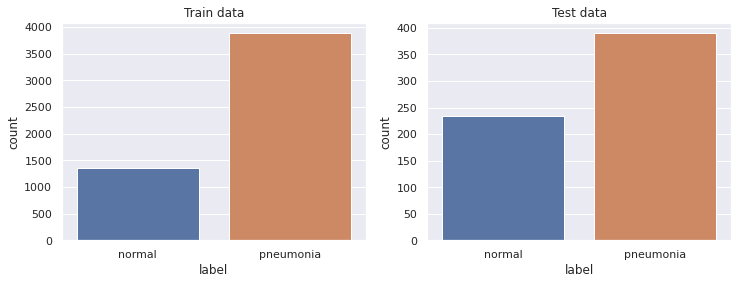

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x = cxr_df[cxr_df['fold'] == 'train']['label'])
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(x = cxr_df[cxr_df['fold'] == 'test']['label'])
plt.title('Test data')

plt.savefig('class_distribution_sns.png')

plt.show()

## Type distribution

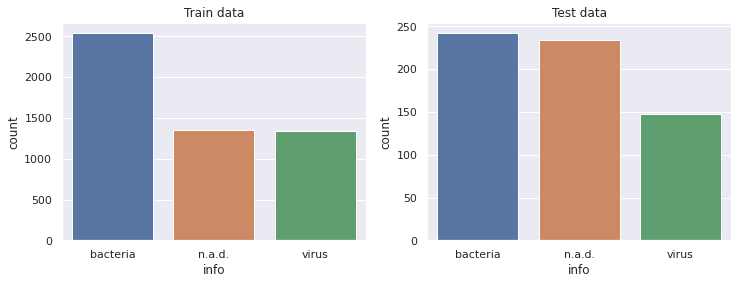

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(x = cxr_df[(cxr_df.fold == 'train')]['info'])
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(x = cxr_df[(cxr_df.fold == 'test')]['info'])
plt.title('Test data')

plt.savefig('type_distribution_.png')

plt.show()

## Show images in the dataset

The helper function for showing the images in the batch.

In [ ]:
def show_batch(batch, size, hspace=0.28, wspace=0.2, title=None):
    """Show the images in the `batch`."""
    height, width = size

    plt.figure(figsize=(10,10))
    
    if title is not None:
        plt.suptitle(title, weight='bold', y=0.96)

    for n in range(height*width):
        ax = plt.subplot(height, width, n+1)
        
        plt.imshow(batch[n][0])
        plt.title(batch[n][1])
        plt.subplots_adjust(wspace=wspace, hspace=hspace)
        plt.axis("off")

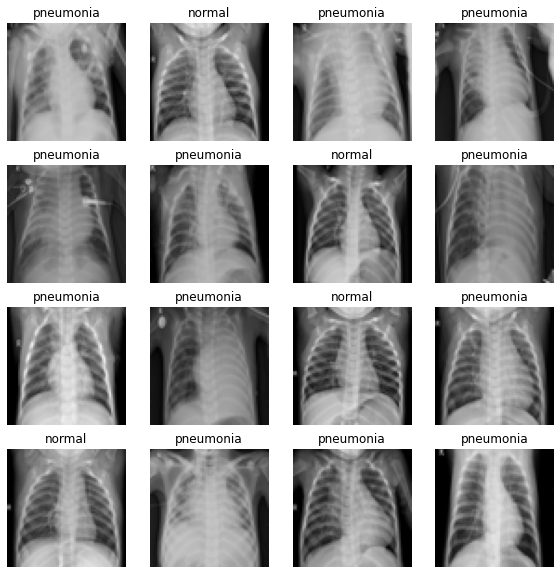

In [ ]:
# random batch from the dataset
sample_batch = cxr_df[['image', 'label']].sample(frac=1).to_numpy()

show_batch(sample_batch, size=(4, 4), hspace=0.2, wspace=0.1)
plt.savefig('sample_batch.png')

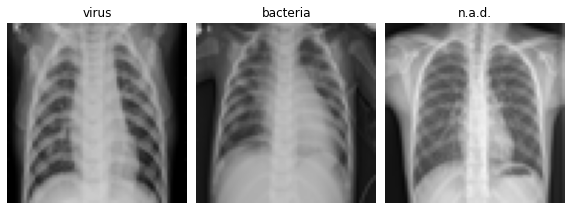

In [ ]:
# get differnt types of images from the dataset (virus, bacterial, n.a.d.)
pneumonia_virus_xray = cxr_df[(cxr_df['label']=='pneumonia') & (cxr_df['info']=='virus')].iloc[0][['image', 'info']]
pneumonia_bacteria_xray = cxr_df[(cxr_df['label']=='pneumonia') & (cxr_df['info']=='bacteria')].iloc[0][['image', 'info']]
normal_xray = cxr_df[(cxr_df['label']=='normal')].iloc[0][['image', 'info']]

sample_batch = [pneumonia_virus_xray, pneumonia_bacteria_xray, normal_xray]
show_batch(sample_batch, size=(1,3), wspace=0.05)

plt.savefig('different_types.png')

---

# 4. CNN model - VGG19 <a name="fourth-bullet"></a>

## Initialize the model

In [ ]:
# input image size
IMAGE_SIZE = (64, 64, 3)

# instantiate a base model with pre-trained weights
vgg19 = VGG19(weights='imagenet',         # load weights pre-trained on ImageNet
              include_top=False,          # do not include the ImageNet classifier at the top
              input_shape=IMAGE_SIZE)  

# freeze the base model
vgg19.trainable = False

# create a new model on top
inputs = keras.Input(shape=IMAGE_SIZE)
x = vgg19(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

80142336/80134624 [==============================] - 0s 0us/step


## Architecture of the base model

In [ ]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## Architecture of the model

In [ ]:
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


---

# 5. Train the model <a name="fifth-bullet"></a>

## Split the data

In [ ]:
train_cxr_df = cxr_df[cxr_df['fold']=='train']
test_cxr_df = cxr_df[cxr_df['fold']=='test']

X_train = np.stack(train_cxr_df['image'].to_numpy())
y_train = train_cxr_df['classID'].to_numpy()

X_test = np.stack(test_cxr_df['image'].to_numpy())
y_test = test_cxr_df['classID'].to_numpy()

## Class weights

In [ ]:
pos, neg = train_cxr_df.label.value_counts().to_numpy()

weight_for_0 = (1 / neg)*(pos+neg)/2.0 
weight_for_1 = (1 / pos)*(pos+neg)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


## Image data preprocessing

In [ ]:
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1.0/255.0)

train_it = datagen.flow(X_train, 
                        y=y_train, 
                        batch_size=BATCH_SIZE, 
                        shuffle=True)

val_it = datagen.flow(X_test, 
                      y=y_test, 
                      batch_size=BATCH_SIZE, 
                      shuffle=False)

## Model training

### a) Train only the trainable layers on top

In [ ]:
EPOCHS = 25

# configure the model for training (Adam, Binary Cross-Entropy, Accuracy)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# train only the trainable layers
history1 = model.fit(train_it, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_it, class_weight=class_weight)

Epoch 1/25
164/164 [==============================] - 4s 22ms/step - loss: 0.7327 - binary_accuracy: 0.2834 - val_loss: 0.6900 - val_binary_accuracy: 0.4904
Epoch 2/25
164/164 [==============================] - 3s 20ms/step - loss: 0.6522 - binary_accuracy: 0.6821 - val_loss: 0.6306 - val_binary_accuracy: 0.7853
Epoch 3/25
164/164 [==============================] - 3s 20ms/step - loss: 0.6086 - binary_accuracy: 0.8389 - val_loss: 0.5961 - val_binary_accuracy: 0.8029
Epoch 4/25
164/164 [==============================] - 3s 20ms/step - loss: 0.5710 - binary_accuracy: 0.8534 - val_loss: 0.5616 - val_binary_accuracy: 0.8285
Epoch 5/25
164/164 [==============================] - 3s 20ms/step - loss: 0.5385 - binary_accuracy: 0.8580 - val_loss: 0.5360 - val_binary_accuracy: 0.8285
Epoch 6/25
164/164 [==============================] - 3s 20ms/step - loss: 0.5104 - binary_accuracy: 0.8605 - val_loss: 0.5205 - val_binary_accuracy: 0.8157
Epoch 7/25
164/164 [==============================] - 3s 2

### b) Fine-tune the model

In [ ]:
EPOCHS_FT = 1

# unfreeze the base model
vgg19.trainable = True

# recompile the model after changing the value of learning rate
model.compile(optimizer=keras.optimizers.Adam(1e-5),  
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[keras.metrics.BinaryAccuracy()])

# train end-to-end
history2 = model.fit(train_it, epochs=EPOCHS_FT, batch_size=BATCH_SIZE, validation_data=val_it, class_weight=class_weight)

164/164 [==============================] - 11s 65ms/step - loss: 0.1233 - binary_accuracy: 0.9522 - val_loss: 0.2973 - val_binary_accuracy: 0.8942


---

# 6. Results <a name="sixth-bullet"></a>

## Helper functions

The function for plotting accuracy and loss graphs for the train and test sets.

In [ ]:
def show_history(history, figsize=(15,5), save_fig=True, print_results=True):
    """Show accuracy and loss graphs for the train and test sets."""    
    
    df = pd.DataFrame(history)

    sns.set()
    plt.figure(figsize=figsize)

    # accuracy graph
    plt.subplot(1,2,1)
    g = sns.lineplot(data=df[['binary_accuracy', 'val_binary_accuracy']], dashes=False)
    g.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy')
    g.legend(labels=['train', 'validation'])

    # loss graph
    plt.subplot(1,2,2)
    g = sns.lineplot(data=df[['loss', 'val_loss']], dashes=False)
    g.set(title='Model loss', xlabel='Epoch', ylabel='Loss')
    g.legend(labels=['train', 'validation'])

    plt.subplots_adjust(wspace=0.23)
    
    if save_fig:
        plt.savefig('acc_loss_graphs.png')

    plt.show()

    if print_results:
        print('\n\tMax train accuracy: %.4f %%\033[0m\t\t\t\tMin train loss: %.5f' % (df.binary_accuracy.max() * 100,
                                                                                      df.loss.min()))
        print('\tMax validation accuracy: %.4f %%\t\t\tMin validation loss: %.5f' % (df.val_binary_accuracy.max() * 100, 
                                                                                     df.val_loss.min()))

---

## a) Accuray and loss graphs

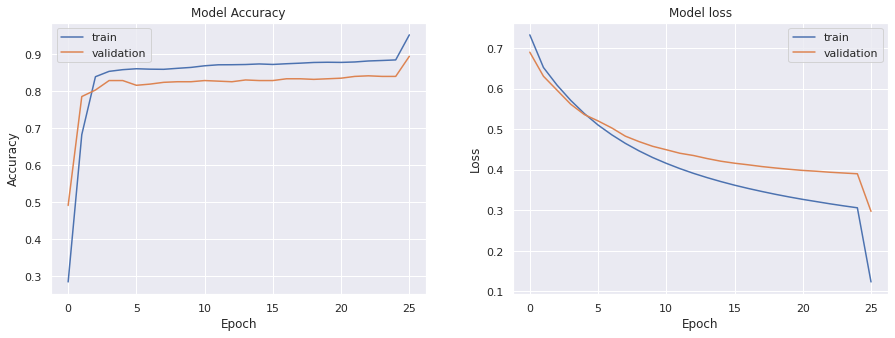


	Max train accuracy: 95.2217 %				Min train loss: 0.12330
	Max validation accuracy: 89.4231 %			Min validation loss: 0.29731


In [ ]:
# append the fine-tuning history to the total history
history1.history['binary_accuracy'] += history2.history['binary_accuracy']
history1.history['val_binary_accuracy'] += history2.history['val_binary_accuracy']
history1.history['loss'] += history2.history['loss']
history1.history['val_loss'] += history2.history['val_loss']

show_history(history1.history)

## b) Confusion matrix

In [ ]:
labels =  ['normal', 'pneumonia']

y_true = y_test
y_pred = tf.round(model.predict(x=val_it, batch_size=BATCH_SIZE)).numpy().T[0]

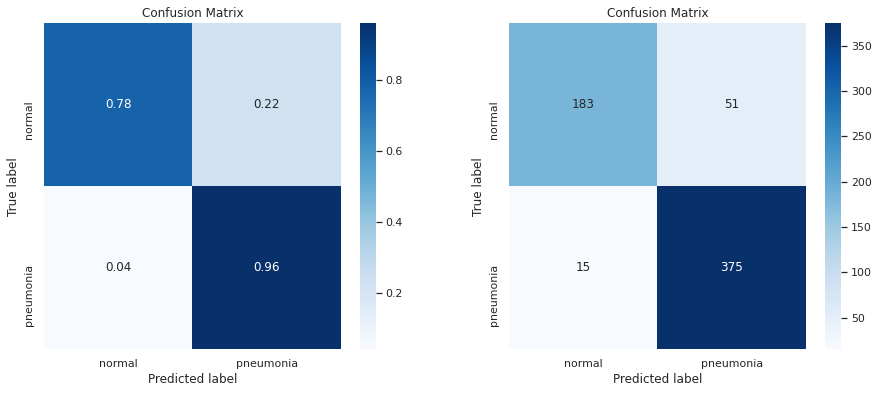

In [ ]:
# compute confusion matrices
cm = confusion_matrix(y_true=y_test, y_pred=y_pred) 
cm_normalized = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true') 

# plot matrices and save the fig.
plt.figure(figsize=(15,6))

for i, cmx in enumerate([cm_normalized, cm]):
    plt.subplot(1,2,i+1)
    cmx_df = pd.DataFrame(cmx, columns=labels, index=labels).round(2)
    g = sns.heatmap(cmx_df, annot=True, fmt='g', cmap='Blues')
    g.set(title='Confusion Matrix', xlabel='Predicted label', ylabel='True label')

plt.subplots_adjust(wspace=0.25)
plt.savefig('confusion_matrices.png')
plt.show()

## c) Precision, Recall and F1-score

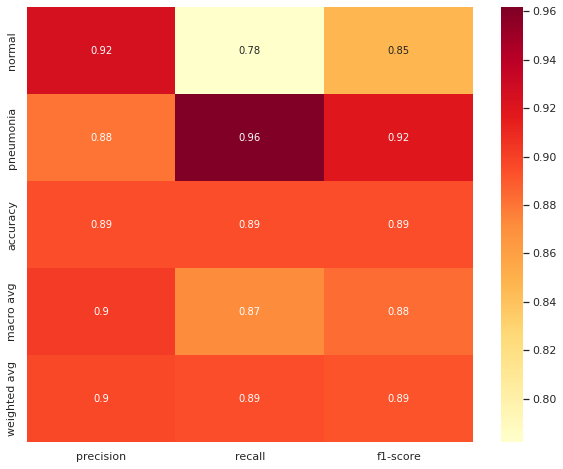

In [ ]:
# compute precision, recall and f1-score
report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'], output_dict=True)
report = pd.DataFrame(report).iloc[:-1, :].T

# plot the classificaton report
plt.figure(figsize=(10,8))
sns.heatmap(report, annot=True, cmap='YlOrRd')
plt.yticks(va='center')
plt.savefig('classifcation_report.png')
plt.show()

## d) Plot top losses


The function for plotting the samples with the highest loss in the dataset.

In [ ]:
def plot_top_losses(k, X, y_true, predict, loss, labels, **kwargs):
    y_pred = predict(x=X, batch_size=BATCH_SIZE)
    loss_values = np.array(loss(y_true, y_pred))
    top_k = loss_values.argsort()[-k:][::-1]

    worst_batch = []
    for idx in top_k:
        true_prob = y_test[idx]*y_pred[idx] + (1-y_test[idx])*(1-y_pred[idx])
        classID = int(y_true[idx])
        title = '%s / %.3f / %.4f' % (labels[classID], loss_values[idx], true_prob)
        worst_batch.append((X[idx], title))

    show_batch(worst_batch, title='Actual/Loss/Prediction_Probability', **kwargs)

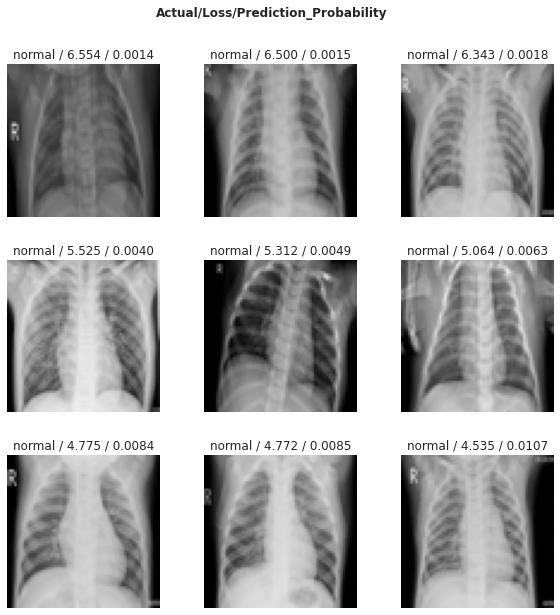

In [ ]:
loss_f = keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

plot_top_losses(k=9,
                X=X_test/255.0, 
                y_true=y_test.reshape(-1, 1),               
                predict=model.predict, 
                loss=loss_f, 
                labels=labels,
                size=(3,3))

plt.savefig('top_losses.png', dpi=350)